# PyTorch Geometric and NetworkX tutorial

# Installation

- PyTorch Geometric (PyG) installationn [link](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html#quick-start)
- Deep Graph Library (DGL) installation [link](https://www.dgl.ai/pages/start.html)
- Networkx installation [link](https://networkx.org/documentation/stable/install.html)

DGL supports PyTorch, Tensorflow and MXNet; PyG supports PyTorch.

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00


# The `Data` object

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

- `data.x`: Node feature matrix with shape [num_nodes, num_node_features]
- `data.edge_index`: Graph connectivity table with shape [2, num_edges] and type torch.long
- `data.edge_attr`: Edge feature matrix with shape [num_edges, num_edge_features]
- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
- `data.pos`: Node position matrix with shape [num_nodes, num_dimensions]

Generally, the most import attribures are `data.x`, `data.edge_index` and `data.y`.

Let's construct an simple undirected graph as an example:

In [4]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


![](2023-04-18-23-43-17.png)

In [6]:
# many attributes
print(data['x'])
print('edge_attr' in data)
print(data.num_nodes)
print(data.num_node_features)
print(data.num_edges)
print(data.num_edge_features)
print(data.is_directed())
print(data.is_undirected())

tensor([[-1.],
        [ 0.],
        [ 1.]])
False
3
1
4
0
False
True


# Common tasks

Some common tasks that GNNs can be used for are:

- Node classification: predicting the labels or properties of individual nodes in a graph.

- Link prediction: predicting the presence or absence of links between pairs of nodes in a graph.

- Graph classification/regression: predicting the label or property of an entire graph.

- Graph clustering: identifying groups of nodes in a graph that are similar or connected in some way.

- Graph generation: generating new graphs that have similar characteristics to a set of input graphs.

# Databatch

Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension. This composition allows differing number of nodes and edges over examples in one batch:
![](2023-04-19-00-17-25.png)

In [7]:
from torch_geometric.datasets import TUDataset   # https://chrsmrrs.github.io/datasets/
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data in loader:
    print(data)
    print(data.num_graphs)
    print(data.batch)  # very important to keep track of the belongings of nodes
    break

Processing...


DataBatch(edge_index=[2, 4072], x=[1096, 21], y=[32], batch=[1096], ptr=[33])
32
tensor([ 0,  0,  0,  ..., 31, 31, 31])


Done!


In [8]:
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import random

random_graphs = []

for _ in range(10):
    # create a random graph using NetworkX
    num_nodes = random.randint(4, 10)
    num_edges = random.randint(15, 25)
    G = nx.gnm_random_graph(num_nodes, num_edges)

    # make the graph undirected
    G = G.to_undirected()

    # convert the NetworkX graph to a PyTorch Geometric graph
    data = from_networkx(G)

    # assign a feature vector of length 10 to each node
    num_features = 10
    node_features = torch.randn(num_nodes, num_features)
    data.x = node_features

    # assign a binary label (0 or 1) to each graph
    label = random.choice([0, 1])
    data.y = torch.tensor([label], dtype=torch.long)

    # add the graph to the list of random graphs
    random_graphs.append(data)

loader = DataLoader(random_graphs, batch_size=4)
for data in loader:
    print(data)
    print(data.num_graphs)
    print(data.batch)  # very important to keep track of the belongings of nodes
    break

DataBatch(edge_index=[2, 114], num_nodes=28, x=[28, 10], y=[4], batch=[28], ptr=[5])
4
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3])


# Learning Methods on Graphs

In [9]:
# first load the Cora dataset
# node classification

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


The constructor defines two GCNConv layers which get called in the forward pass of our network. Note that the non-linearity is not integrated in the conv calls and hence needs to be applied afterwards (something which is consistent across all operators in PyG). Here, we chose to use ReLU as our intermediate non-linearity and finally output a softmax distribution over the number of classes.

- [Here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) is a list of all graph convolutional layers;
- Different [aggregation operations](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#aggregation-operators) could boost the performance;

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(loss.item())

1.9346624612808228
1.8073285818099976
1.65718674659729
1.4894312620162964
1.344151258468628
1.1898856163024902
1.023470401763916
0.9074805378913879
0.8300314545631409
0.6989991068840027


In [14]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7880


# Visualizing a graph with NetworkX

[NetworkX](https://networkx.org/) is a Python package used for the creation, manipulation, and study of complex networks or graphs. It provides a variety of tools for working with graph data structures, including algorithms for analyzing graphs, creating random graphs, and visualizing graphs.

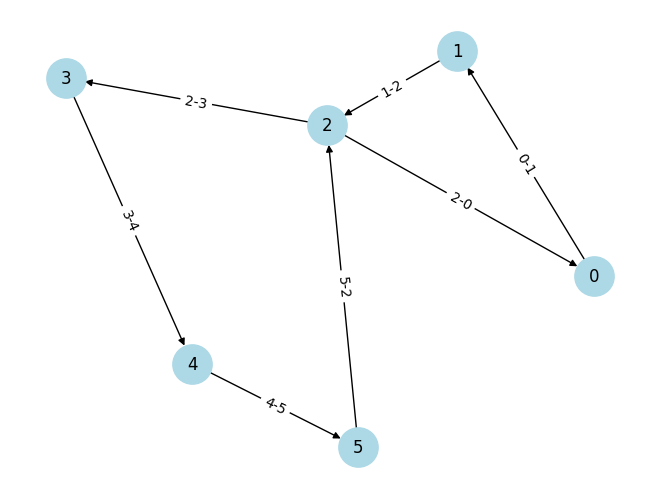

In [15]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

# create a PyTorch Geometric graph (you can replace this with your graph)
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (3, 4), (4, 5), (5, 2)]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(edge_index=edge_index)

# convert the PyTorch Geometric graph to a NetworkX graph
G = nx.DiGraph(data.edge_index.t().tolist())

# visualize the NetworkX graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{u}-{v}' for u, v in G.edges()})
plt.show()


A complete list of `Data` attributes can be found [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)

# Reference
- PyG tutorial: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
- NetworkX tutorial: https://networkx.org/documentation/stable/tutorial.html